In [1]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet101
 
import numpy as np
import matplotlib.pyplot as plt
import os
from patchify import patchify, unpatchify  # Only to handle large images
import random
from PIL import Image
from datasets import Dataset


from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import os
import numpy as np

/home/sprasad/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def prepare_model(num_classes=2):
    model = deeplabv3_resnet101(weights='DEFAULT')
    model.classifier[4] = nn.Conv2d(256, num_classes, 1)
    model.aux_classifier[4] = nn.Conv2d(256, num_classes, 1)
    return model

In [2]:


def load_and_pad_images_from_folder(folder, target_size=(1024, 1536)):
    images = []
    filenames = []
    for filename in sorted(os.listdir(folder)):  # Sort the filenames
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path).convert('RGB')  # Ensure image is in RGB
            img_array = np.array(img)
            # Pad the image
            pad_width = ((0, 0), (0, target_size[1] - img_array.shape[1]), (0, 0))
            padded_img = np.pad(img_array, pad_width, mode='constant', constant_values=0)
            images.append(padded_img)
            filenames.append(filename)
    return np.array(images), filenames

def load_and_pad_masks_from_folder(folder, target_size=(1024, 1536)):
    masks = []
    filenames = []
    for filename in sorted(os.listdir(folder)):  # Sort the filenames
        mask_path = os.path.join(folder, filename)
        if os.path.isfile(mask_path):
            mask = np.load(mask_path)
            # Pad the mask
            pad_width = ((0, 0), (0, target_size[1] - mask.shape[1]))
            padded_mask = np.pad(mask, pad_width, mode='constant', constant_values=0)
            masks.append(padded_mask)
            filenames.append(filename)
    return np.array(masks), filenames


In [3]:
# Folder paths
image_folder_path = r'/data1/sprasad/data/train/image2'
mask_folder_path = r'/data1/sprasad/data/train/label2'

# Load and pad images and masks
large_images, image_filenames = load_and_pad_images_from_folder(image_folder_path)
large_masks, mask_filenames = load_and_pad_masks_from_folder(mask_folder_path)

# Ensure the filenames are sorted and correspond
image_filenames = sorted(image_filenames)
mask_filenames = sorted(mask_filenames)

# Print shapes
print(f'Shape of large_images: {large_images.shape}')  # Should be (18, 1024, 1536, 3)
print(f'Shape of large_masks: {large_masks.shape}')    # Should be (18, 1024, 1536)

# Desired patch size for smaller images and step size.
patch_size = 256
step = 256
all_img_patches = []
all_mask_patches = []
all_patch_filenames = []

for img_idx in range(large_images.shape[0]):
    large_image = large_images[img_idx]
    patches_img = patchify(large_image, (patch_size, patch_size, 3), step=step)  # Step=256 for 256 patches means no overlap

    large_mask = large_masks[img_idx]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :, :]
            single_patch_mask = patches_mask[i, j, :, :]

            all_img_patches.append(single_patch_img)
            all_mask_patches.append(single_patch_mask)

            # Generate a patch filename for tracking
            patch_filename = f"{image_filenames[img_idx].split('.')[0]}_patch_{i}_{j}.npy"
            all_patch_filenames.append(patch_filename)

images = np.array(all_img_patches)/255.0
masks = np.array(all_mask_patches)

# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]

# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
filtered_filenames = [all_patch_filenames[i] for i in valid_indices]

print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

# Remove the extra dimension from images
filtered_images = np.squeeze(filtered_images, axis=1)


Shape of large_images: (23, 1024, 1536, 3)
Shape of large_masks: (23, 1024, 1536)
Image shape: (291, 1, 256, 256, 3)
Mask shape: (291, 256, 256)


In [4]:


class SemanticSegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            # Apply transformations
            image = self.transform(image)
            #mask = self.transform(mask)
            mask=torch.tensor(mask, dtype=torch.long)

        return image, mask


In [5]:
# Normalizing and transforming images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Create dataset instances
train_dataset = SemanticSegmentationDataset(filtered_images, filtered_masks, transform=transform)
test_dataset = SemanticSegmentationDataset(filtered_images, filtered_masks, transform=transform)  # Use separate data for testing in practice


# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4,drop_last=True)

In [7]:
device =torch.device('cuda' if torch.cuda.is_available() else 'gpu')
model = prepare_model(1).to(device)



criterion = nn.BCEWithLogitsLoss() 

# Training loop


optimizer = optim.Adam(model.parameters(), lr=1e-4)

#model.train()


In [1]:
def jaccard_index(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    preds = preds.bool()  # Convert to boolean for bitwise operations
    targets = targets.bool()  # Convert to boolean for bitwise operations

    intersection = (preds & targets).float().sum((1, 2))
    union = (preds | targets).float().sum((1, 2))
    iou = (intersection + 1e-10) / (union + 1e-10)  # avoid division by zero
    return iou.mean()  # return mean IoU over the batch


In [9]:

num_epochs = 50


save_dir = '/data1/sprasad/Deeplabv3/deeplabv3_pytorch/weights2/weights_next'

model.load_state_dict(torch.load('/data1/sprasad/Deeplabv3/deeplabv3_pytorch/weights2/model_epoch_51.pth'))

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    for images, masks in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        #print(images.shape)
        outputs = model(images)['out']
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    # Save model after each epoch
    save_path = os.path.join(save_dir, f'model_epoch_{epoch}.pth')
    torch.save(model.state_dict(), save_path)

    # Compute mean loss for the epoch
    mean_loss = np.mean(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean_loss:.4f}')

    # Evaluate on validation set
    model.eval()
    iou_scores = []
    with torch.no_grad():
        for val_images, val_masks in test_loader:
            val_images = val_images.float().to(device)
            val_masks = val_masks.float().to(device)

            val_outputs = model(val_images)['out']
            val_outputs = torch.sigmoid(val_outputs)

            iou = jaccard_index(val_outputs, val_masks)
            iou_scores.append(iou.cpu().numpy())

    mean_iou = np.mean(iou_scores)
    print(f'Mean Jaccard Index: {mean_iou:.4f}')



100%|██████████| 145/145 [00:09<00:00, 14.90it/s]


EPOCH: 0
Mean loss: 0.1431
Mean Jaccard Index: 0.4886


100%|██████████| 145/145 [00:10<00:00, 14.13it/s]


EPOCH: 1
Mean loss: 0.1279
Mean Jaccard Index: 0.5342


100%|██████████| 145/145 [00:10<00:00, 14.00it/s]


EPOCH: 2
Mean loss: 0.1330
Mean Jaccard Index: 0.5339


100%|██████████| 145/145 [00:10<00:00, 13.40it/s]


EPOCH: 3
Mean loss: 0.0904
Mean Jaccard Index: 0.5302


100%|██████████| 145/145 [00:10<00:00, 13.43it/s]


EPOCH: 4
Mean loss: 0.1309
Mean Jaccard Index: 0.5366


100%|██████████| 145/145 [00:08<00:00, 17.03it/s]


EPOCH: 5
Mean loss: 0.1176
Mean Jaccard Index: 0.5361


100%|██████████| 145/145 [00:08<00:00, 16.39it/s]


EPOCH: 6
Mean loss: 0.0839
Mean Jaccard Index: 0.5380


100%|██████████| 145/145 [00:10<00:00, 13.82it/s]


EPOCH: 7
Mean loss: 0.2683
Mean Jaccard Index: 0.5058


100%|██████████| 145/145 [00:09<00:00, 15.80it/s]


EPOCH: 8
Mean loss: 0.1546
Mean Jaccard Index: 0.5279


100%|██████████| 145/145 [00:08<00:00, 16.26it/s]


EPOCH: 9
Mean loss: 0.1228
Mean Jaccard Index: 0.5316


100%|██████████| 145/145 [00:09<00:00, 15.20it/s]


EPOCH: 10
Mean loss: 0.0798
Mean Jaccard Index: 0.5392


100%|██████████| 145/145 [00:10<00:00, 14.15it/s]


EPOCH: 11
Mean loss: 0.1800
Mean Jaccard Index: 0.5132


100%|██████████| 145/145 [00:09<00:00, 15.06it/s]


EPOCH: 12
Mean loss: 0.1259
Mean Jaccard Index: 0.5185


100%|██████████| 145/145 [00:11<00:00, 12.96it/s]


EPOCH: 13
Mean loss: 0.0855
Mean Jaccard Index: 0.5177


100%|██████████| 145/145 [00:09<00:00, 14.98it/s]


EPOCH: 14
Mean loss: 0.0791
Mean Jaccard Index: 0.5244


100%|██████████| 145/145 [00:10<00:00, 13.68it/s]


EPOCH: 15
Mean loss: 0.0665
Mean Jaccard Index: 0.5235


100%|██████████| 145/145 [00:10<00:00, 14.19it/s]


EPOCH: 16
Mean loss: 0.0610
Mean Jaccard Index: 0.5334


100%|██████████| 145/145 [00:09<00:00, 14.68it/s]


EPOCH: 17
Mean loss: 0.0645
Mean Jaccard Index: 0.5205


100%|██████████| 145/145 [00:10<00:00, 14.45it/s]


EPOCH: 18
Mean loss: 0.1237
Mean Jaccard Index: 0.5104


100%|██████████| 145/145 [00:10<00:00, 13.68it/s]


EPOCH: 19
Mean loss: 0.0731
Mean Jaccard Index: 0.5212


100%|██████████| 145/145 [00:10<00:00, 13.71it/s]


EPOCH: 20
Mean loss: 0.0763
Mean Jaccard Index: 0.5265


100%|██████████| 145/145 [00:09<00:00, 14.63it/s]


EPOCH: 21
Mean loss: 0.0638
Mean Jaccard Index: 0.5192


100%|██████████| 145/145 [00:09<00:00, 14.52it/s]


EPOCH: 22
Mean loss: 0.0549
Mean Jaccard Index: 0.5340


100%|██████████| 145/145 [00:10<00:00, 14.13it/s]


EPOCH: 23
Mean loss: 0.0546
Mean Jaccard Index: 0.5165


100%|██████████| 145/145 [00:10<00:00, 13.86it/s]


EPOCH: 24
Mean loss: 0.0458
Mean Jaccard Index: 0.5425


100%|██████████| 145/145 [00:10<00:00, 14.14it/s]


EPOCH: 25
Mean loss: 0.0613
Mean Jaccard Index: 0.5243


100%|██████████| 145/145 [00:09<00:00, 15.18it/s]


EPOCH: 26
Mean loss: 0.0600
Mean Jaccard Index: 0.5431


100%|██████████| 145/145 [00:10<00:00, 14.16it/s]


EPOCH: 27
Mean loss: 0.0478
Mean Jaccard Index: 0.5398


100%|██████████| 145/145 [00:10<00:00, 14.19it/s]


EPOCH: 28
Mean loss: 0.0480
Mean Jaccard Index: 0.5416


100%|██████████| 145/145 [00:10<00:00, 13.71it/s]


EPOCH: 29
Mean loss: 0.0796
Mean Jaccard Index: 0.5261


100%|██████████| 145/145 [00:08<00:00, 16.72it/s]


EPOCH: 30
Mean loss: 0.0798
Mean Jaccard Index: 0.5161


100%|██████████| 145/145 [00:08<00:00, 16.56it/s]


EPOCH: 31
Mean loss: 0.0890
Mean Jaccard Index: 0.4919


100%|██████████| 145/145 [00:10<00:00, 14.13it/s]


EPOCH: 32
Mean loss: 0.2421
Mean Jaccard Index: 0.3999


100%|██████████| 145/145 [00:10<00:00, 13.53it/s]


EPOCH: 33
Mean loss: 0.1479
Mean Jaccard Index: 0.4906


100%|██████████| 145/145 [00:10<00:00, 13.68it/s]


EPOCH: 34
Mean loss: 0.0791
Mean Jaccard Index: 0.5207


100%|██████████| 145/145 [00:10<00:00, 13.42it/s]


EPOCH: 35
Mean loss: 0.0745
Mean Jaccard Index: 0.5047


100%|██████████| 145/145 [00:10<00:00, 14.39it/s]


EPOCH: 36
Mean loss: 0.0551
Mean Jaccard Index: 0.5393


100%|██████████| 145/145 [00:10<00:00, 13.28it/s]


EPOCH: 37
Mean loss: 0.0524
Mean Jaccard Index: 0.5210


100%|██████████| 145/145 [00:10<00:00, 13.40it/s]


EPOCH: 38
Mean loss: 0.0484
Mean Jaccard Index: 0.5409


100%|██████████| 145/145 [00:10<00:00, 13.47it/s]


EPOCH: 39
Mean loss: 0.0446
Mean Jaccard Index: 0.5143


100%|██████████| 145/145 [00:15<00:00,  9.36it/s]


EPOCH: 40
Mean loss: 0.0407
Mean Jaccard Index: 0.5398


100%|██████████| 145/145 [00:08<00:00, 16.63it/s]


EPOCH: 41
Mean loss: 0.0387
Mean Jaccard Index: 0.5134


100%|██████████| 145/145 [00:10<00:00, 13.70it/s]


EPOCH: 42
Mean loss: 0.0415
Mean Jaccard Index: 0.5406


100%|██████████| 145/145 [00:09<00:00, 14.78it/s]


EPOCH: 43
Mean loss: 0.0364
Mean Jaccard Index: 0.5167


100%|██████████| 145/145 [00:10<00:00, 13.96it/s]


EPOCH: 44
Mean loss: 0.0877
Mean Jaccard Index: 0.4956


100%|██████████| 145/145 [00:10<00:00, 14.14it/s]


EPOCH: 45
Mean loss: 0.0930
Mean Jaccard Index: 0.5314


100%|██████████| 145/145 [00:08<00:00, 17.10it/s]


EPOCH: 46
Mean loss: 0.0543
Mean Jaccard Index: 0.5044


100%|██████████| 145/145 [00:10<00:00, 14.08it/s]


EPOCH: 47
Mean loss: 0.2203
Mean Jaccard Index: 0.5025


100%|██████████| 145/145 [00:08<00:00, 16.19it/s]


EPOCH: 48
Mean loss: 0.1046
Mean Jaccard Index: 0.5264


100%|██████████| 145/145 [00:10<00:00, 14.25it/s]


EPOCH: 49
Mean loss: 0.0636
Mean Jaccard Index: 0.5323


In [10]:
model.load_state_dict(torch.load(r'/data1/sprasad/Deeplabv3/deeplabv3_pytorch/weights2/weights_next/model_epoch_26.pth'))

<All keys matched successfully>

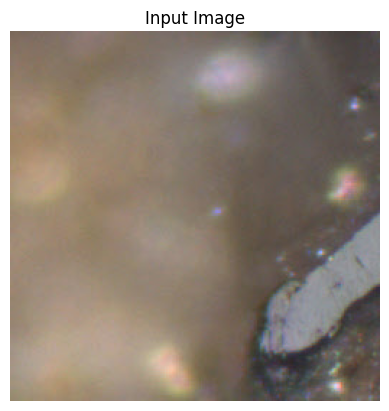

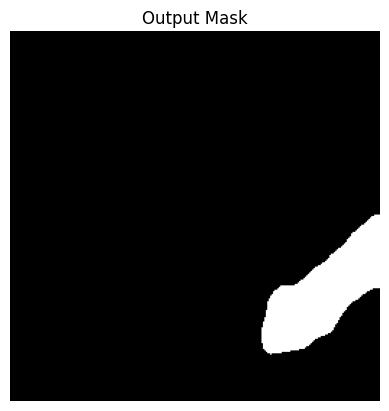

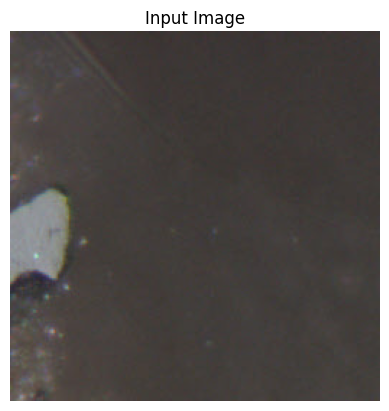

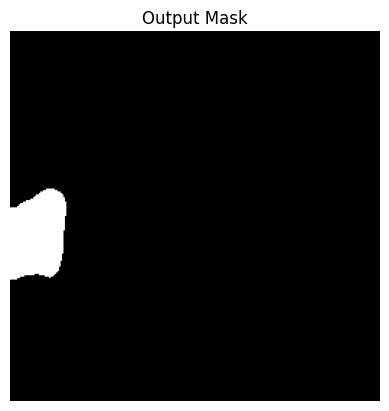

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming mean and std are already defined
mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)

for batch in test_loader:
    inputs, _ = batch  # Unpack inputs and targets (we ignore targets here)
    inputs = inputs.float().to(device)
    
    # Get model output
    outputs = model(inputs)['out']
    outputs = torch.sigmoid(outputs)
    
    # Iterate over each image in the batch
    for i in range(inputs.size(0)):
        img = inputs[i]
        output = outputs[i]
        
        img = img.permute(1, 2, 0)
        
        img = std * img + mean
        img = img.clamp(0, 1)  # To ensure values are within [0, 1] range
        
        output = output.squeeze(0)
        output = (output > 0.5).float()
        
        img = img.cpu().detach().numpy()
        output = output.cpu().detach().numpy()
        
        # Plot the original image
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        plt.show()
        
        # Plot the output mask
        plt.imshow(output, cmap='gray')
        plt.title("Output Mask")
        plt.axis('off')
        plt.show()
        
    # Break after processing one batch for demonstration purposes
    break


## Prediction

In [12]:
# Load and pad images
image_folder_path = r'/data1/sprasad/data/test_class_2/Class2_sep_test'
large_test_images, image_ids = load_and_pad_images_from_folder(image_folder_path)
print(f'Shape of large_test_images: {large_test_images.shape}')  # Should be (13, 1024, 1536, 3)

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Shape of large_test_images: (9, 1024, 1536, 3)


In [13]:
# Apply the transformation to each image
transformed_images = [transform(img) for img in large_test_images]
transformed_images = torch.stack(transformed_images)
# Convert to NumPy and change shape to (13, 1024, 1536, 3)
final_images = transformed_images.permute(0, 2, 3, 1).numpy()
final_images = final_images.astype(np.float32)

# Define the patch size and step size
patch_size = 256
step_size = patch_size  # No overlap

# Directory to save the reconstructed images
output_dir = 'predictionForClass2New'
os.makedirs(output_dir, exist_ok=True)

In [15]:
model.eval()
# Process each image in the dataset
for img_idx in range(final_images.shape[0]):
    # Extract patches from the image
    patches = patchify(final_images[img_idx], (patch_size, patch_size, 3), step=step_size)
    patches = np.squeeze(patches, axis=2)

    # Initialize array to store predicted patches
    predicted_patches = np.zeros((patches.shape[0], patches.shape[1], patch_size, patch_size), dtype=np.float32)

    # Process each patch
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j]
            patch = torch.from_numpy(patch).float().to(device)
            patch = patch.permute((2, 0, 1)).unsqueeze(0)

            

            with torch.no_grad():
                outputs = model(patch)['out']
            
            # Apply sigmoid and threshold
            outputs = outputs.sigmoid().cpu().numpy().squeeze(0).squeeze(0)
            predicted_label = (outputs > 0.5).astype(np.float32)  # Adjust threshold as needed

            predicted_patches[i, j] = predicted_label

    # Unpatchify to reconstruct the image without grid lines
    reconstructed_image = unpatchify(predicted_patches, (final_images.shape[1], final_images.shape[2]))
    
    reconstructed_image=reconstructed_image[:,:1360]
    reconstructed_image=reconstructed_image*1

    # Save the reconstructed image with the correct filename
    image_id = image_ids[img_idx]
    save_path = os.path.join(output_dir, f"{image_id}_pred.npy")
    np.save(save_path, reconstructed_image)

In [18]:
mask_np=np.load('/data1/sprasad/Deeplabv3/deeplabv3_pytorch/predictionForClass3/vyo284.JPG_pred.npy')

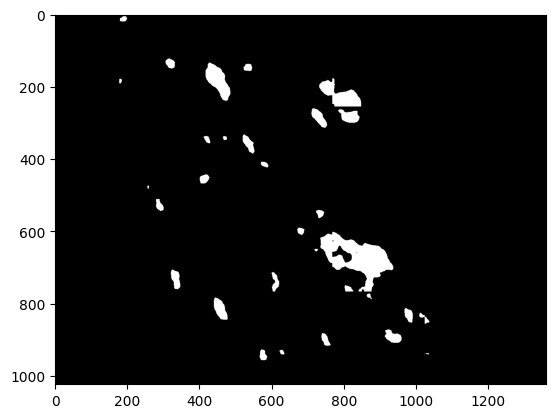

In [19]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 

# Load the numpy array
mask_np = np.load('/data1/sprasad/Deeplabv3/deeplabv3_pytorch/predictionForClass3/vyo284.JPG_pred.npy')

plt.imshow(mask_np,cmap='gray')

